In [1]:
backtest_frame_path = 'E:\\backtest-frame'
data_path = "E:\\base_data"
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.size'] = '20' # 设置字体大小 = '16' # 设置字体大小
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import sys 
sys.path.append(backtest_frame_path)
import numba

from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool,cpu_count



In [5]:

from Data import Data
from TimingFactor import TimingFactor
from BackTest import BackTest
from TDayProcessor import TDayProcessor
from TushareDownloader import TushareDownloader
from utils import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

date_col = 'TradingDay'
secu_col = 'SecuCode'
key_col = [date_col,secu_col]

In [6]:
DB = Data(data_path,update=False)

In [4]:
df = TushareDownloader.pro.moneyflow(trade_date='20190315')

In [10]:
DB.moneyflow_df

0it [00:00, ?it/s]


# 一、动量类因子

## 1.1 长端动量因子

In [14]:
df = DB.daily_df.copy()
df['Amplitude'] = (df['high'] - df['low']) / df['low']
df = df.merge(DB.ret_df,on=key_col,how='left')
df = df.dropna()

In [9]:
_df = df.loc[0:10,['Amplitude','raw_close_close']]
_df.iloc[0,0] = np.nan

data = _df.values

# indicator = ~numba.any(np.isnan(data),axis=1)
data = data[indicator,:]

# data[data[:,0] <= np.quantile(data[:,0],0.5),1].mean()

NameError: name 'indicator' is not defined

In [15]:
@numba.jit(nopython=True)
def calc_mom_numba(data):
    # indicator = ~numba.any(np.isnan(data),axis=1)
    data = data[~np.isnan(data[:,0]),:]
    data = data[~np.isnan(data[:,1]),:]
    
    return data[data[:,0] <= np.quantile(data[:,0],0.5),1].mean()

def _calc_mom(se):
    _df = df.loc[se.index,['Amplitude','raw_close_close']]
    
    return calc_mom_numba(_df.values)

    
df.groupby('SecuCode').rolling(160,min_periods=120)['Amplitude'].apply(lambda x: _calc_mom(x))
# pool = Pool(12)
# rst_iter = pool.imap(_calc_mom, list(df.groupby('SecuCode').rolling(20)))
# rst_list = list(tqdm(rst_iter,total = len(df)))

# pool.close()
# pool.join()

In [ ]:
rst = dict()
for _df in tqdm(df.groupby('SecuCode').rolling(160), total=len(df)):
    if _df.shape[0]  < 120:
        continue
    rst[_df.index.values[-1]] = _df[_df['Amplitude'] <= _df['Amplitude'].median()]['raw_close_close'].sum()
    
factor_col = 'mom_longEndMom_160D'
factor_se = pd.Series(rst).rename(factor_col)
df[factor_col] = factor_se
factor_df = df[['TradingDay','SecuCode','mom_longEndMom_160D']]

In [38]:
# factor_df = pd.('../factors/mom_longEndMom_160D.csv',index_col = 0)
# factor_df['SecuCode'] = factor_df['SecuCode'].astype(str).str.pad(6,side='left',fillchar='0')
# factor_df['TradingDay'] = factor_df['TradingDay'].astype('datetime64[ns]')
# factor_df.head(3)
factor_df = pd.read_pickle('../factors/mom_longEndMom_160D.pkl')
factor_df.to_pickle('../factors/mom_longEndMom_160D.pkl')

1. Factor Histogram


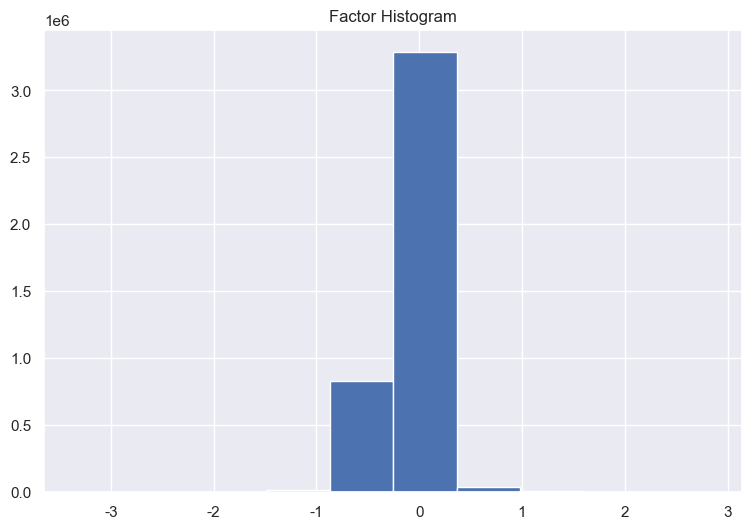

2. Quantile ts plot


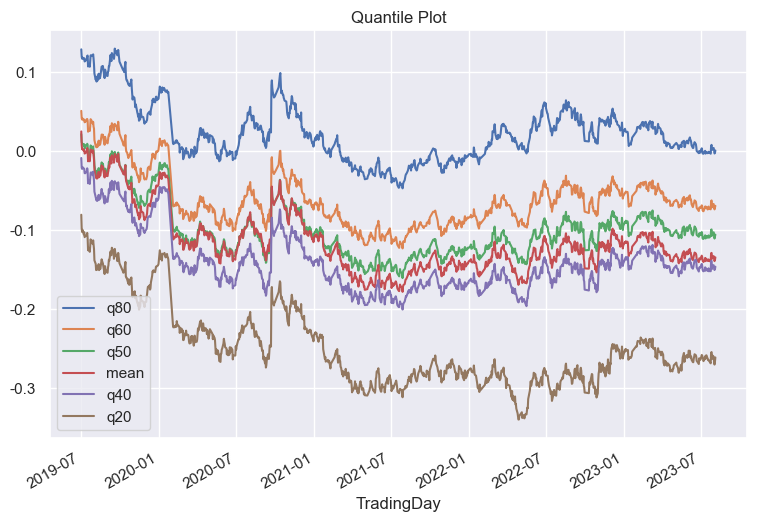

3. Factor Autocorrelation


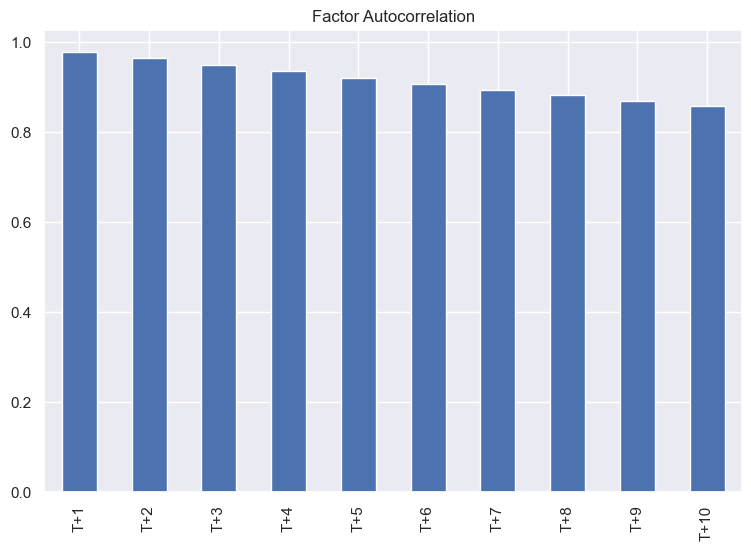

4. Factor Correlation


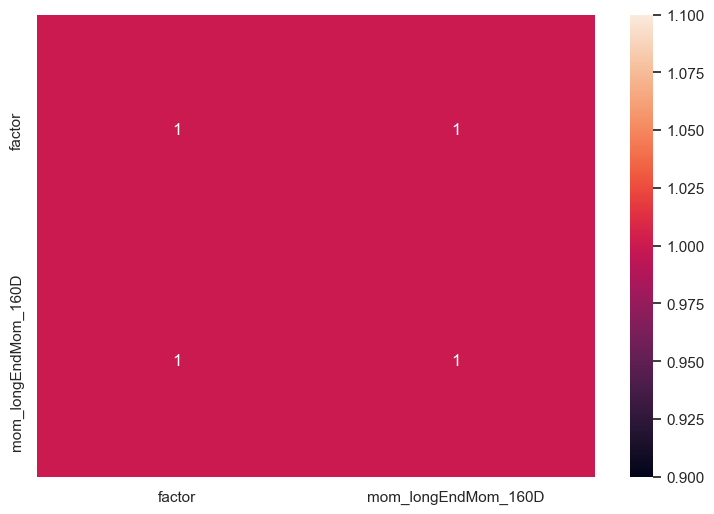

,IC(%),t-value,IC+(%),IC-(%),RankIC(%),ICIR,Winning Rate(%),IC_Min(%),IC_Max(%)
total,2.826474,10.668400,0.764883,2.082617,4.644049,0.383102,66.666667,-24.384848,26.729938
2019,2.065390,5.600159,0.322744,1.739515,4.396836,0.595580,74.400000,-11.458177,9.803656
2020,2.642631,5.001266,0.641923,1.995065,3.659170,0.416764,66.666667,-13.654122,26.729938
2021,2.768510,4.902577,0.964603,1.797358,4.449914,0.381580,67.489712,-24.384848,19.665549
2022,2.602754,4.953540,0.778468,1.824731,4.605632,0.298558,62.396694,-19.809732,23.755608
2023,4.281266,5.551937,0.937625,3.340606,6.928659,0.475973,65.734266,-21.533810,25.205964


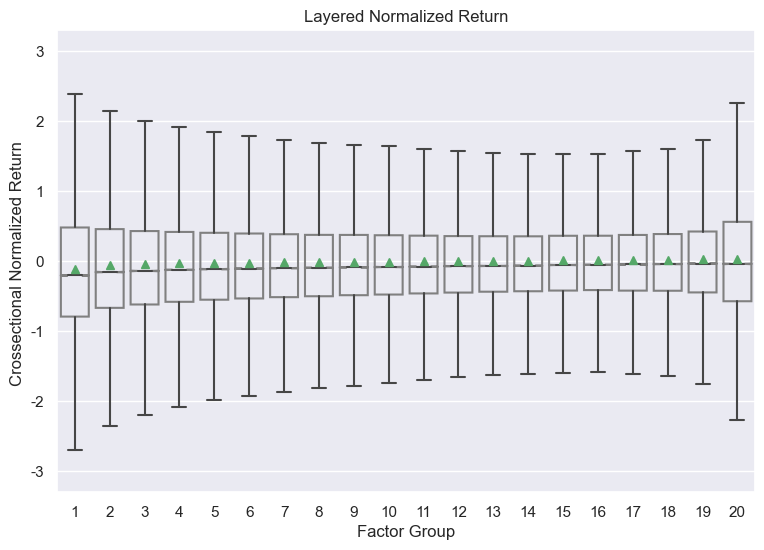

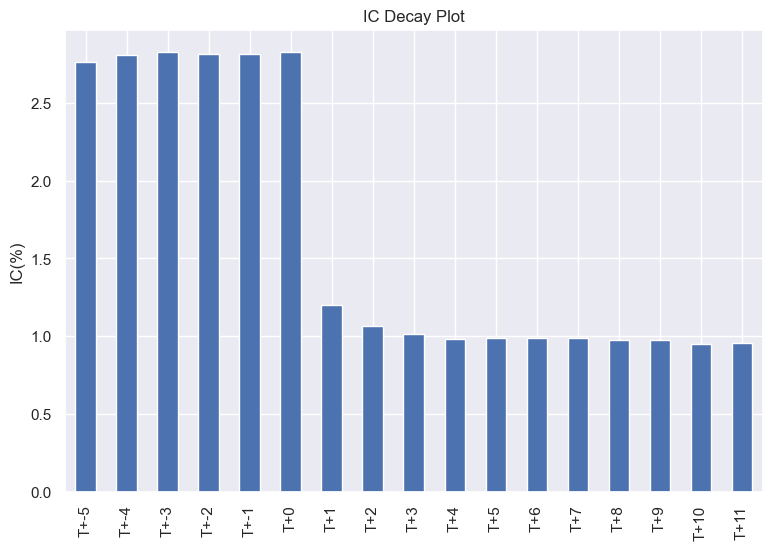

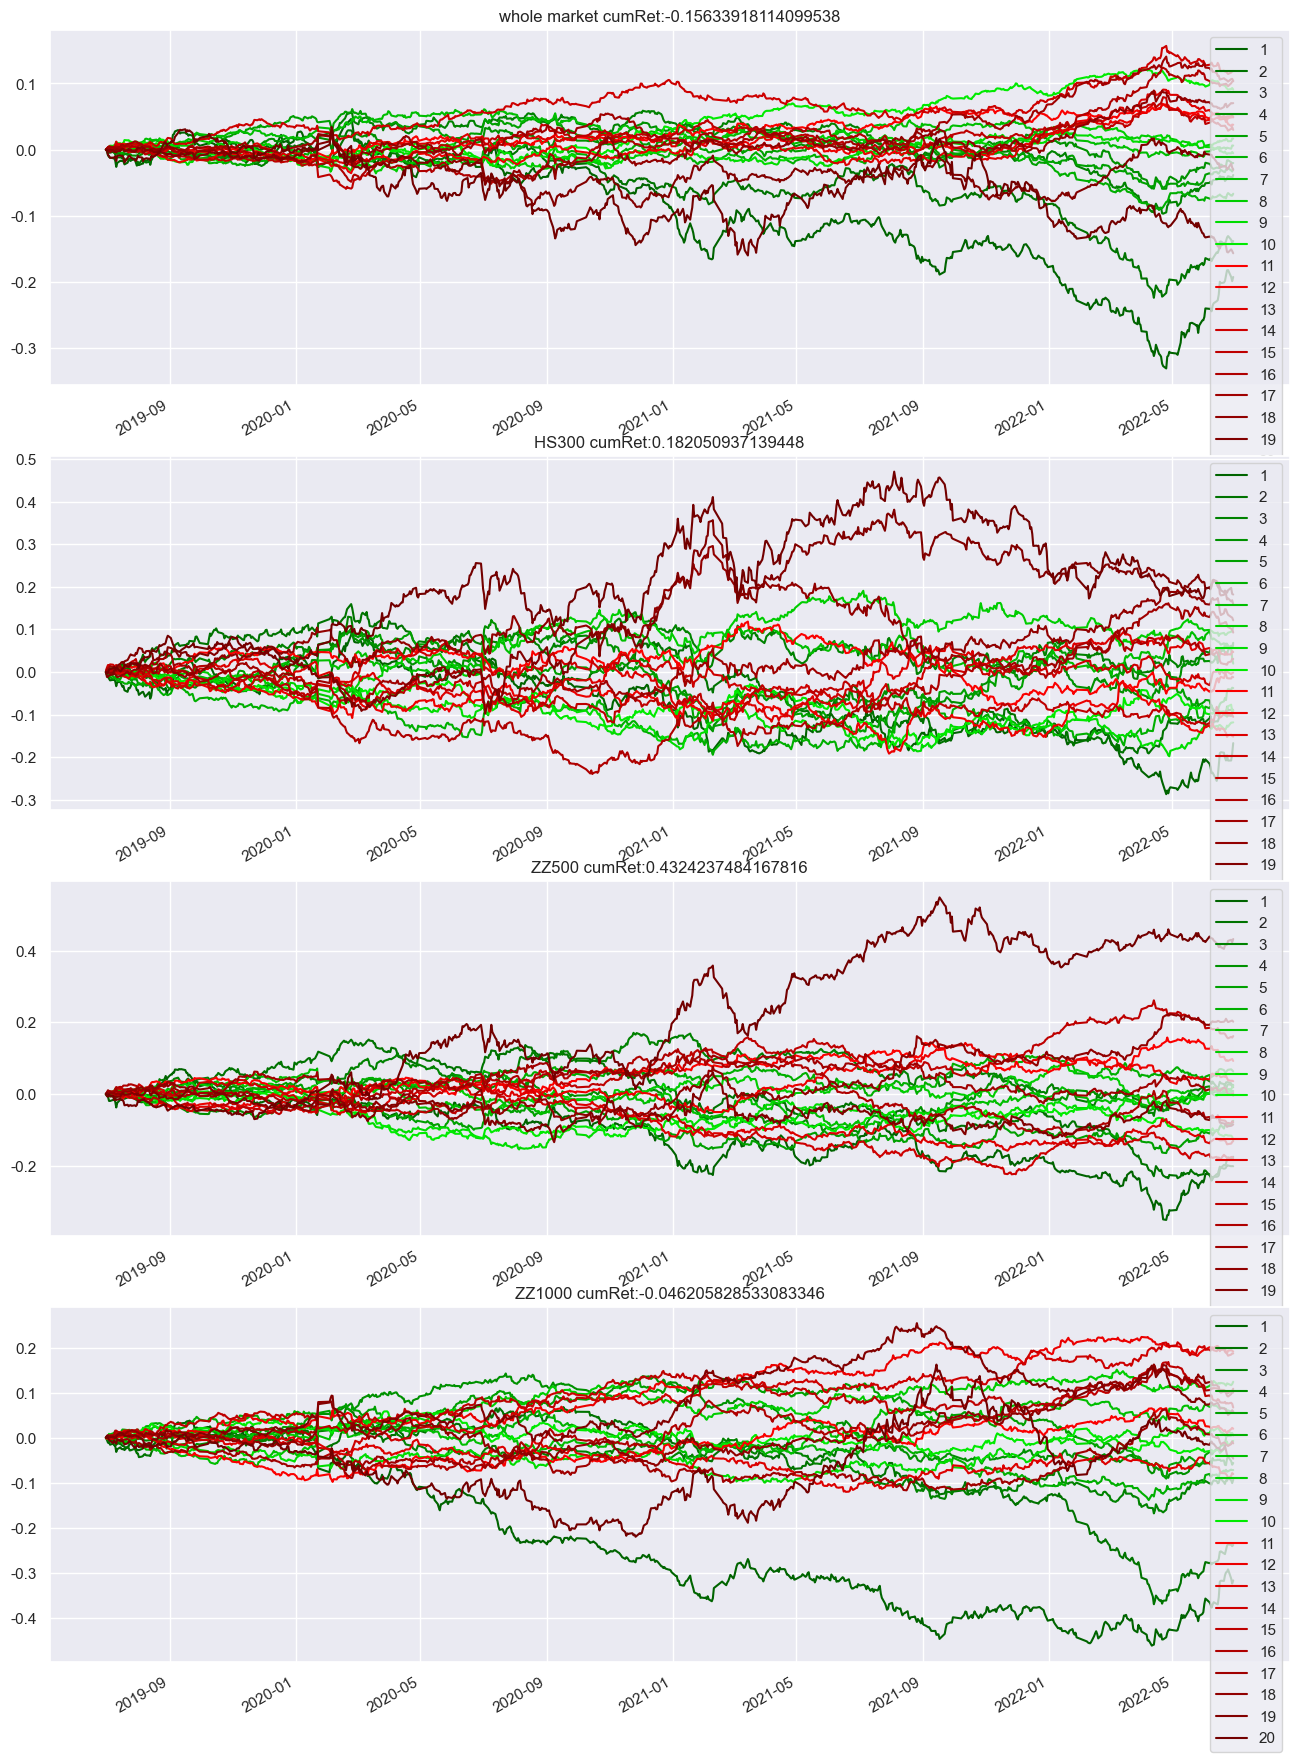

<Figure size 900x600 with 0 Axes>

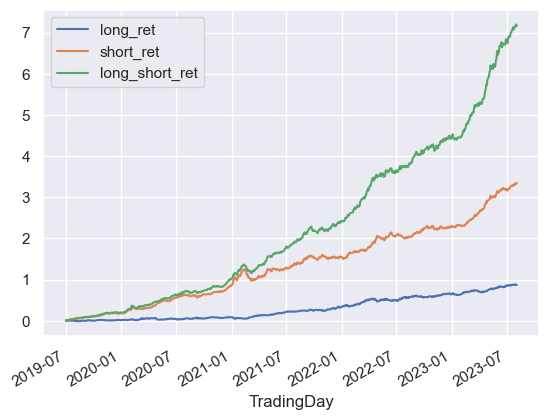

In [57]:
BT = BackTest(factor_df)
BT.wrapped_analysis(DB.ret_df)
# BT.return_analysis(DB.ret_df)

## 1.2 小单动量因子

In [59]:
moneyflow_df = DB.moneyflow_df

100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


In [64]:
[col for col in moneyflow_df.columns if ('amount' in col)]
# DB.daily_df

['buy_sm_amount',
 'sell_sm_amount',
 'buy_md_amount',
 'sell_md_amount',
 'buy_lg_amount',
 'sell_lg_amount',
 'buy_elg_amount',
 'sell_elg_amount',
 'net_mf_amount']

# 测试

In [52]:
factor_df

,TradingDay,SecuCode,mom_longEndMom_160D
425802,2019-07-02,000001,0.007950
425803,2019-07-02,000002,-0.148979
425805,2019-07-02,000005,-0.069138
425806,2019-07-02,000006,-0.026541
425807,2019-07-02,000007,-0.443255
...,...,...,...
4798578,2023-08-04,873169,-0.104695
4798579,2023-08-04,873223,-0.008958
4798580,2023-08-04,873305,-0.074745
4798581,2023-08-04,873339,-0.117125


In [54]:

from TushareDownloader import TushareDownloader

In [ ]:
TushareDownloader.download_index_all('20190101','20190601','399300.SZ')

('20190901', '20191002')